In [69]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

# Data loading

In [70]:
data = pd.read_csv('ovary.tsv', sep="\t", index_col=0)
adata = ad.AnnData(data.T)
adata.var_names = data.index  # Gene names
adata.obs_names = data.columns  # Cell names
adata

AnnData object with n_obs × n_vars = 7549 × 11943

# Processing

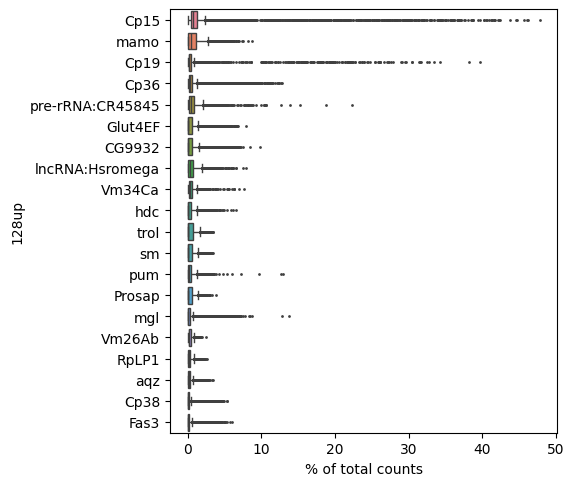

In [71]:
sc.pl.highest_expr_genes(adata, n_top=20) #show the top expressed genes in raw counts

Chorion membrane (egg shell) protein: plays a role in protecting the egg from the environment.

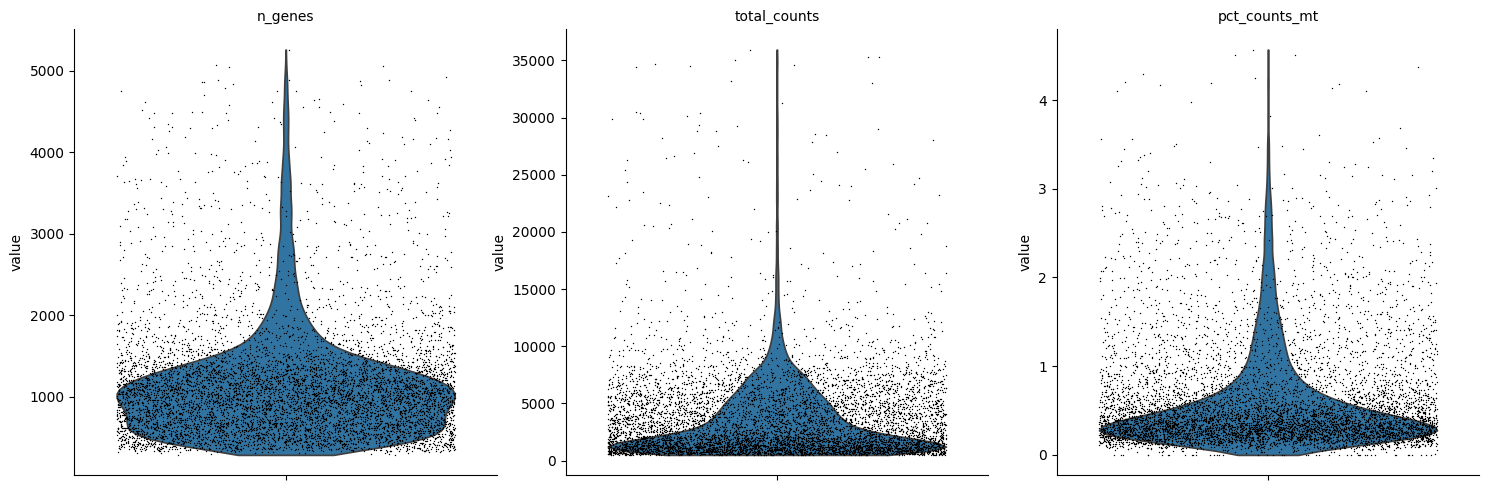

In [72]:
# Compute QC Metrics
adata.var_names_make_unique()  # Ensure gene names are unique
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)  # Number of genes per cell
adata.obs['total_counts'] = adata.X.sum(axis=1)  # Total counts per cell
adata.var['n_cells'] = (adata.X > 0).sum(axis=0)  # Number of cells per gene

# Identify mitochondrial genes (assuming they start with "MT-") → High mt% = low-quality cells (apoptotic)
adata.var["mt"] = adata.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

# Plot QC Metrics
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Apply QC Filters
min_genes = 100     # Cells must have at least 200 genes
max_genes = 3000     # Remove doublets with too many genes
min_counts = 100
max_mito = 4        # Max mitochondrial content (%)

# Apply filtering
sc.pp.filter_cells(adata, min_counts=min_counts) # Remove **empty droplets** (cells with extremely low counts)
sc.pp.filter_cells(adata, max_counts=15000) # TODO: exist?
sc.pp.filter_cells(adata, max_genes=max_genes) # Remove cells with too many genes (doublets)
sc.pp.filter_cells(adata, min_genes=min_genes) # Remove cells with too low genes
sc.pp.filter_genes(adata, min_cells=1) # Remove genes not expressed in any cell
adata = adata[adata.obs['pct_counts_mt'] < max_mito, :]  # Remove cells with high mt content


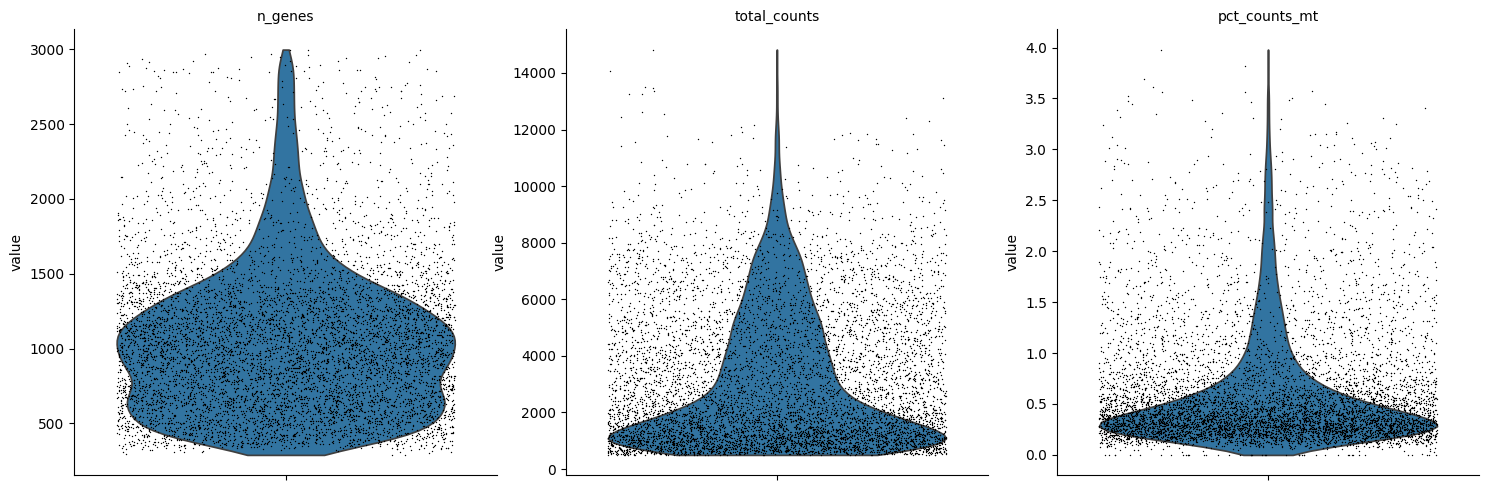

In [73]:
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

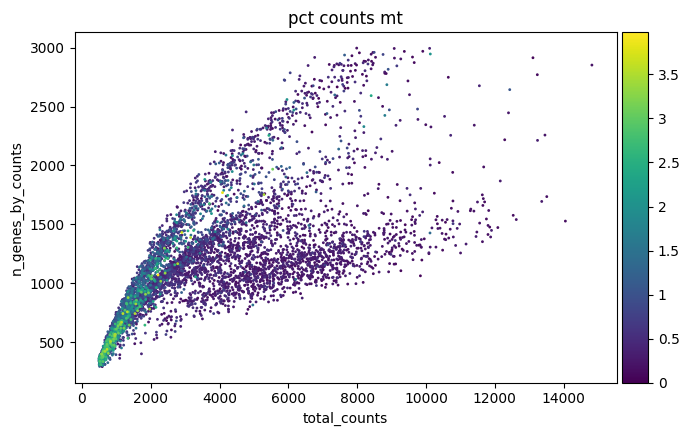

/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [74]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Normalize & Log Transform
sc.pp.normalize_total(adata, target_sum=1e6)  # Normalize per cell
sc.pp.log1p(adata)  # Log-transform data

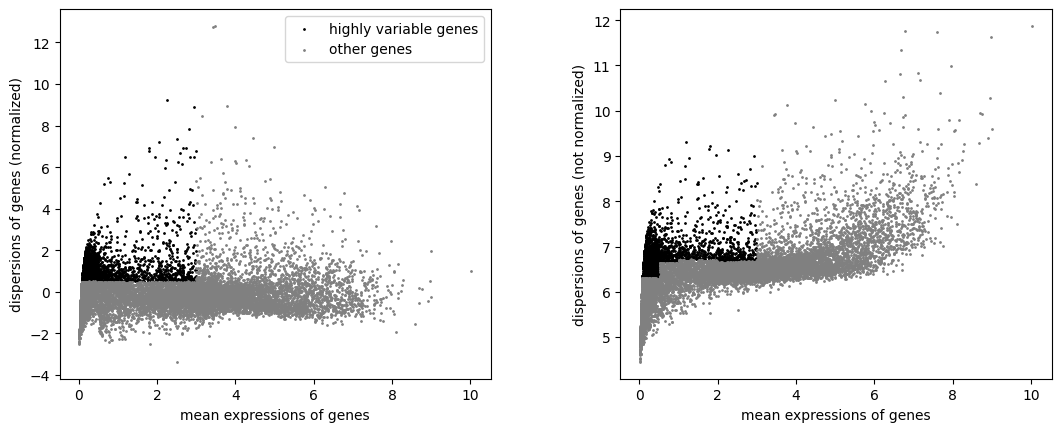

In [75]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [76]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [77]:
sc.pp.scale(adata, max_value=10)

In [78]:
sc.tl.pca(adata, svd_solver="arpack")

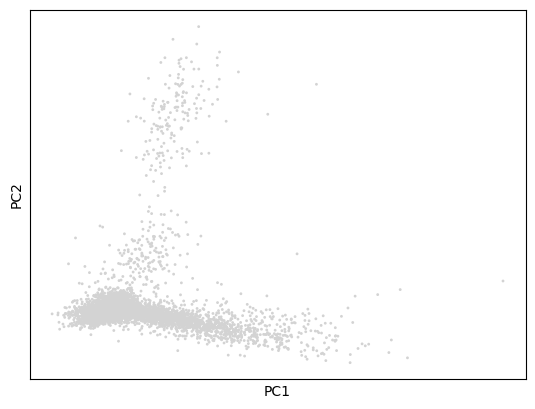

In [79]:
sc.pl.pca(adata)

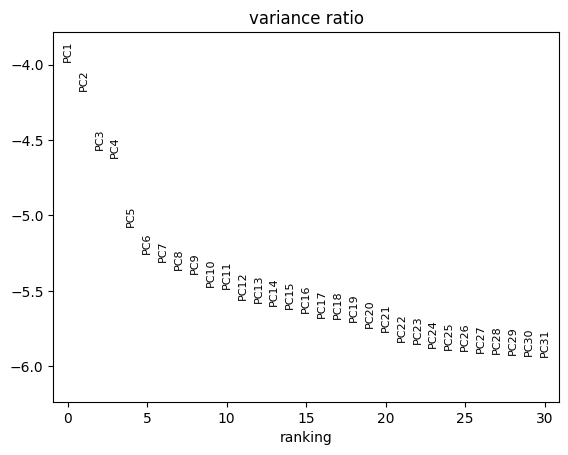

In [80]:
sc.pl.pca_variance_ratio(adata, log=True)

In [81]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=22)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')

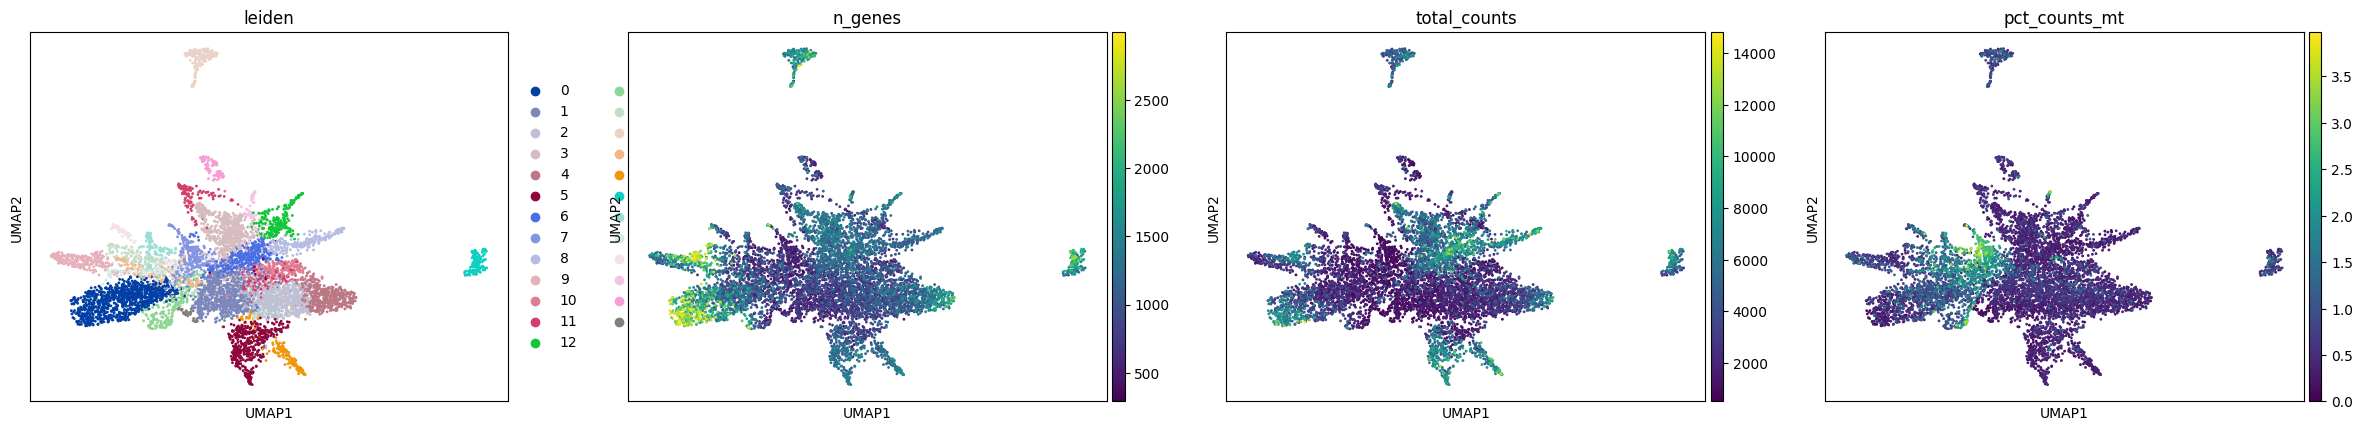

In [82]:
sc.pl.umap(adata, color=["leiden", "n_genes", "total_counts", "pct_counts_mt"])

Clusters Cells → Uses sc.tl.leiden() or sc.tl.louvain() to group similar cells.
Paga builds a Cluster Graph → Computes connectivity between clusters based on transcriptomic similarity.
Visualizes Connectivity → sc.pl.paga(adata) shows the abstracted graph, and sc.tl.umap(adata, init_pos='paga') initializes UMAP using this structure for better layout.

/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py

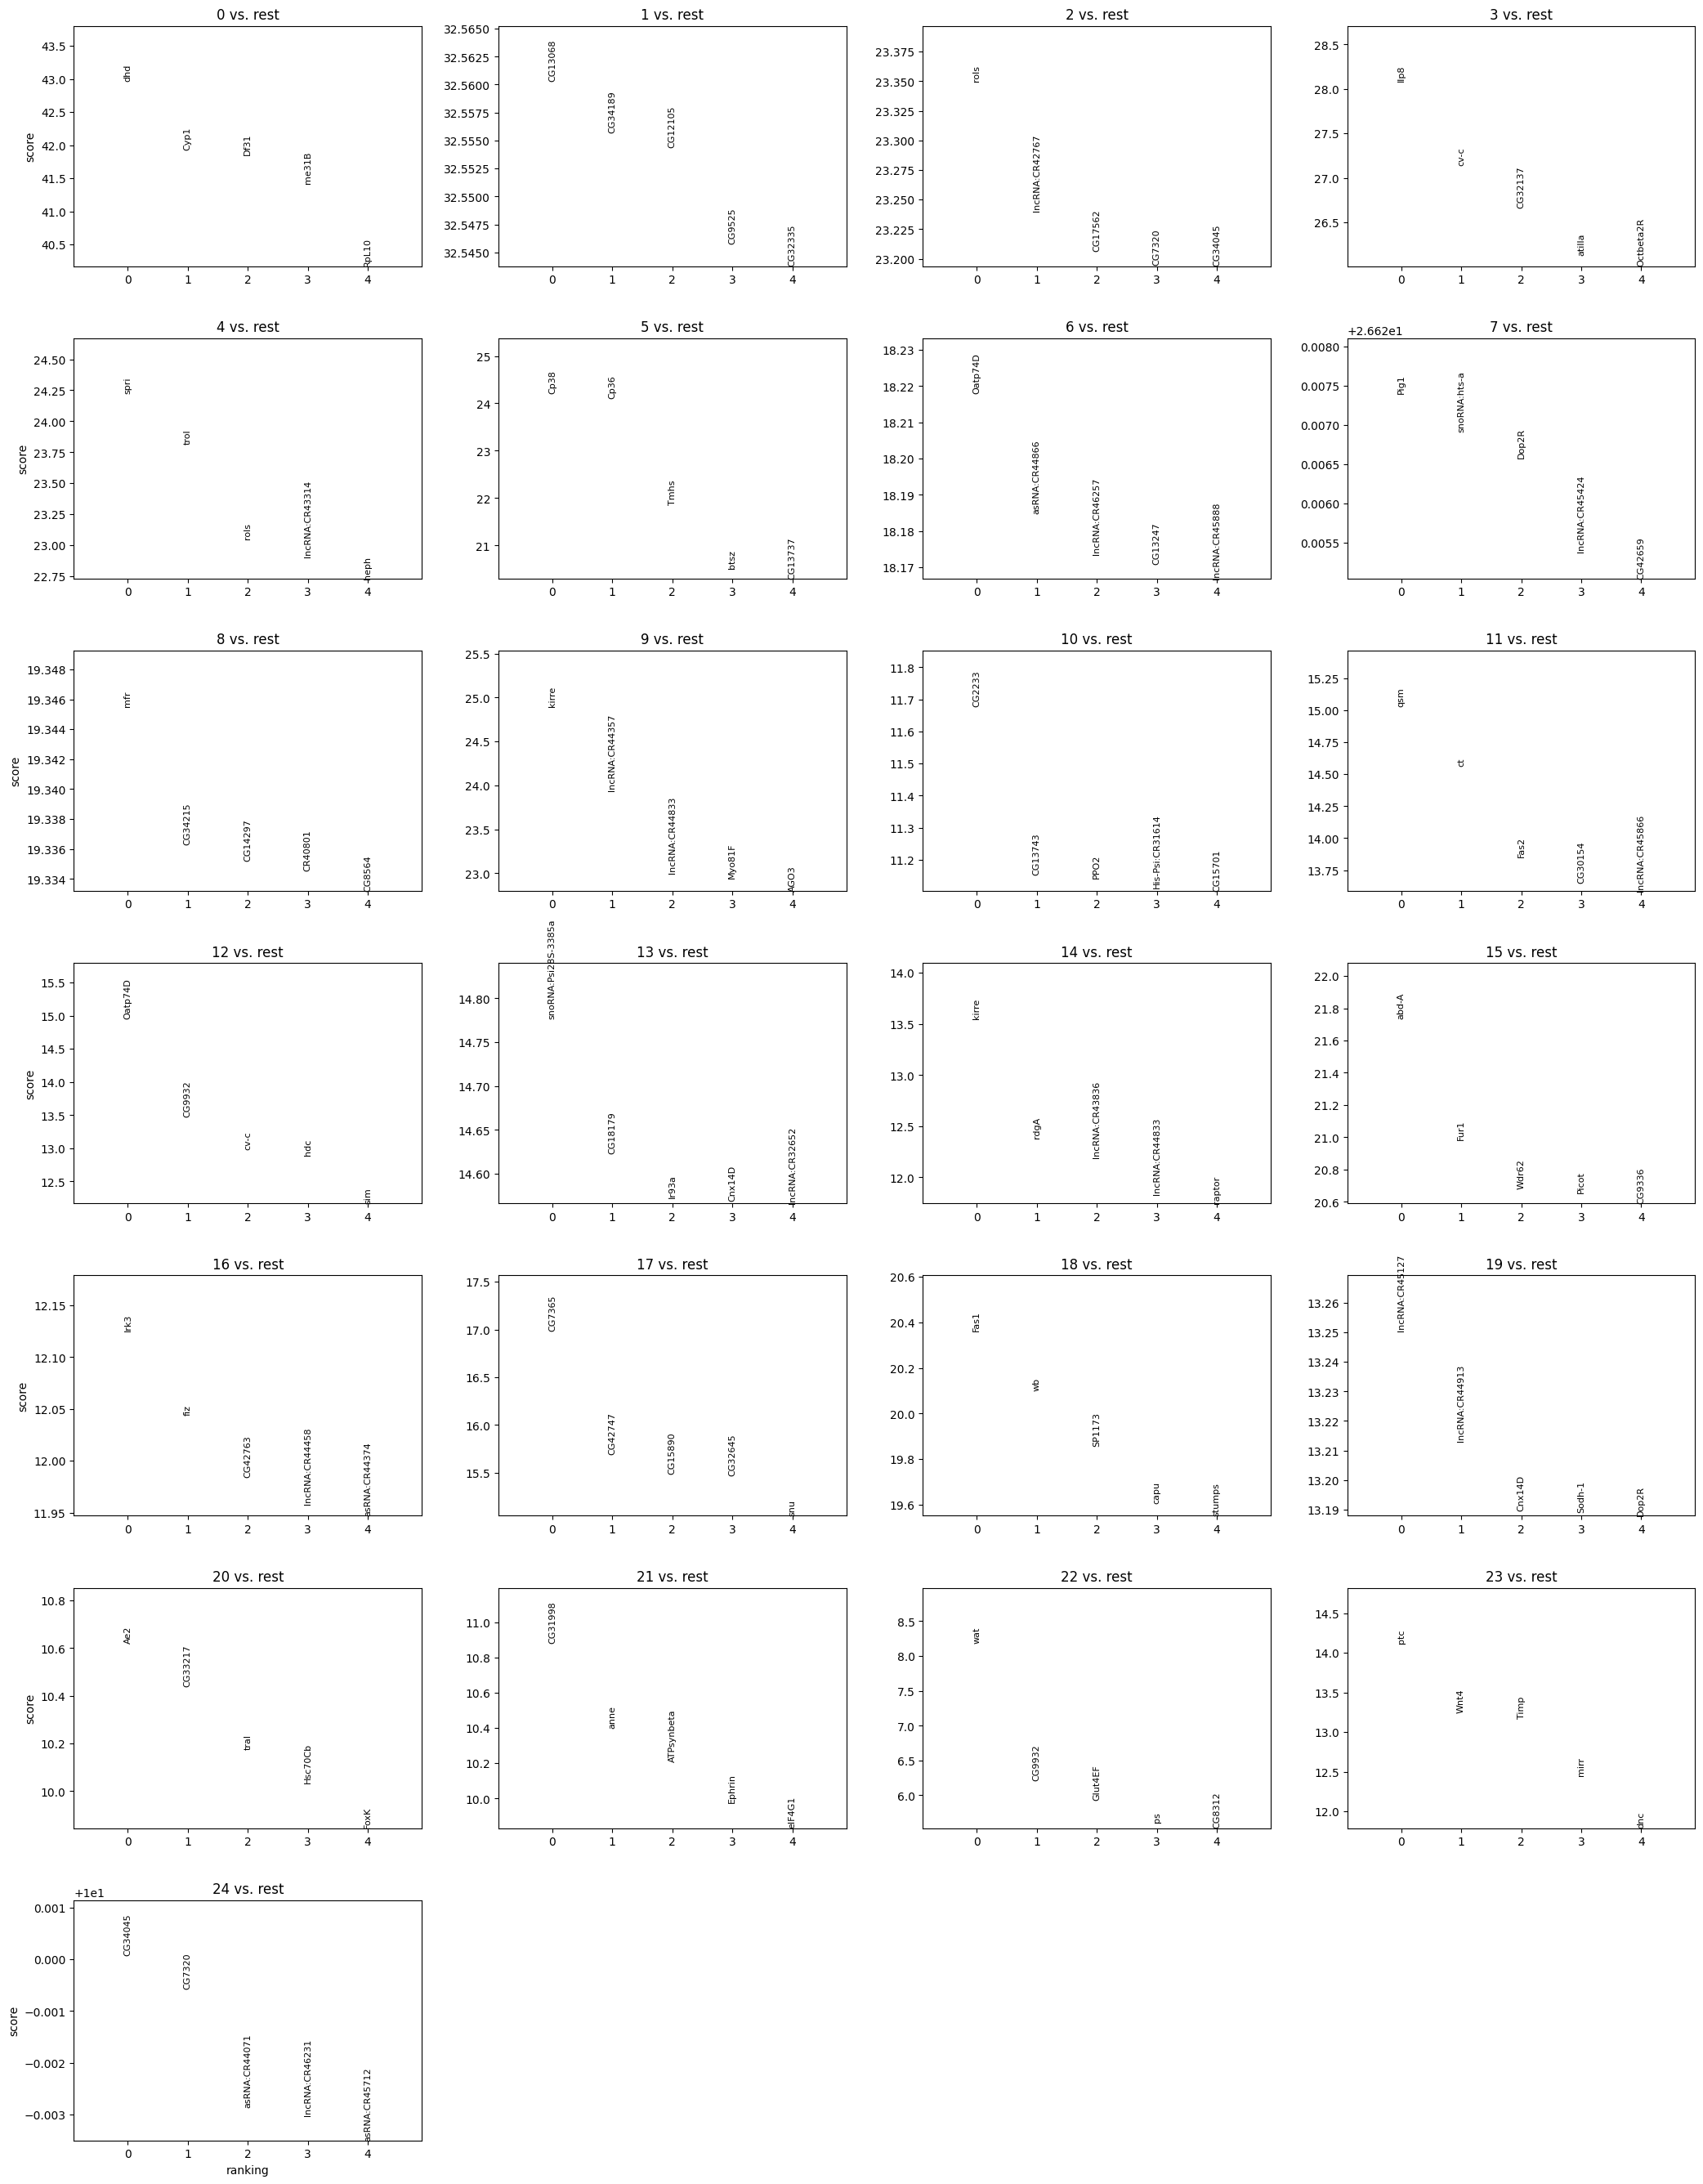

In [84]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)